<a href="https://colab.research.google.com/github/codernayeem/mini-flower/blob/main/notebooks/mini_flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini Flower Classification (5 classes)
 
We are going to make a flowers classification model for 5 classes
 
These are : **daisy, dandelion, roses, sunflowers, tulips**
 
we are going to use **TensorFlow v2.4.2**, **EfficientNetB0** and the **dataset** from **tensorflow example**

## Getting Started

In [1]:
# to make sure efficientnet works fine (as tf v2.5.0 has some bugs)
!pip -q install tensorflow==2.4.2

     |████████████████████████████████| 394.5MB 38kB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
     |████████████████████████████████| 2.9MB 41.0MB/s 
     |████████████████████████████████| 471kB 58.4MB/s 


In [2]:
# imports
import numpy as np
import pandas as pd
import os, json
from os.path import join
 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# checking GPU & TensorFlow version
!nvidia-smi -L
print(tf.__version__)

GPU 0: Tesla T4 (UUID: GPU-f880d985-2d3e-83da-e8a1-252c35a4017d)
2.4.2


In [4]:
# helper module 'utils.py' from @codernayeem/dl-practice
!wget https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
import utils

--2021-07-19 13:24:46--  https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19239 (19K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  18.79K  --.-KB/s    in 0s      

2021-07-19 13:24:46 (145 MB/s) - ‘utils.py’ saved [19239/19239]



In [5]:
# mount Google Drive for use later
utils.mount_gdrive()
gdrive_path = "/content/drive/MyDrive/Saved_Models/mini_flower/v1_efficientnetb0"
 
# creating folder for this project if not exists
utils.create_dir(gdrive_path)

Mounted at /content/drive


## Downloading and visualise our images dataset

In [7]:
ds_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=ds_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir

228818944/228813984 [==============================] - 1s 0us/step


'/root/.keras/datasets/flower_photos'

In [8]:
utils.print_class_files(data_dir)

Directory : /root/.keras/datasets/flower_photos
  - Found 799 tulips
  - Found 699 sunflowers
  - Found 641 roses
  - Found 898 dandelion
  - Found 633 daisy


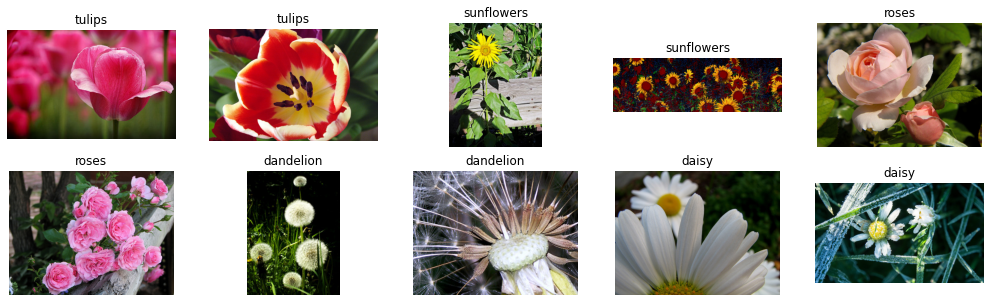

In [9]:
utils.plot_images(*utils.random_imgs(data_dir, equal_img_per_class=2),
                  from_dir=True,
                  single_figsize=(3.5, 2.5))

## Imporing & Processing our dataset using `image_dataset_from_directory`

In [10]:
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224) # for EfficientNetB0
SEED = 42

In [11]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    label_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SHAPE,
                                                    seed=SEED,
                                                    validation_split=0.2,
                                                    subset='training')

val_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    label_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SHAPE,
                                                    seed=SEED,
                                                    validation_split=0.2,
                                                    subset='validation')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
print('Total Batches :', len(train_data), '+', len(val_data))

Total Batches : 92 + 23


In [13]:
class_names = train_data.class_names
num_classes = len(class_names)
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [14]:
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, val_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>)

#### Again Visualise

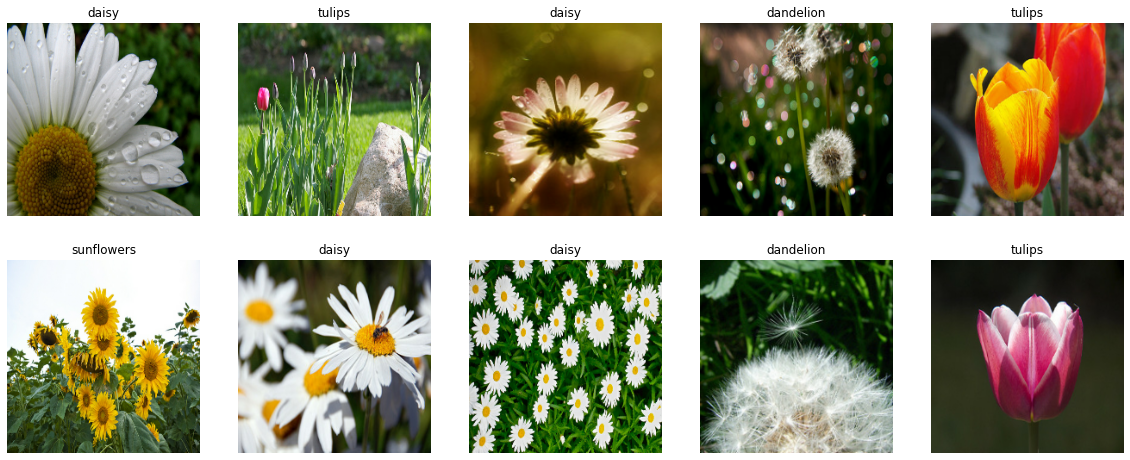

In [15]:
for images, labels in train_data.take(1):
  utils.plot_images(images[:10], labels[:10], class_names=class_names, rescale=1/255)

## Building Model

### Prepare our Models roadmap
* Create A **Feature Extraction** Model using **EfficientNetB0**
* **Fine Tune** the **Feature Extraction** Model

### Feature Extraction with EfficientNetB0

In [16]:
# creating data augmentation layer
data_aug_layer = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [17]:
# Creating Feature Extraction Model with Data Augmentation
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
 
inputs = layers.Input(shape=(*IMAGE_SHAPE, 3), name="input_layer")
x = data_aug_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
 
model = tf.keras.Model(inputs, outputs)
 
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


Let's create a `ModelCheckPoint` and `EarlyStopping` Callback

In [18]:
checkpoint_path = "checkpoints/feature_extraction_model/checkpoint.ckpt"
 
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

# if val_accuracy decreases for 3 epochs in a row, stop training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [19]:
history_1 = model.fit(train_data,
                      epochs=50, # maximum 50 epochs
                      callbacks=[utils.create_tensorboard_callback('training_logs', 'feature_extraction_model'),
                                checkpoint_callback,
                                early_stopping],
                      steps_per_epoch=len(train_data),
                      validation_data=val_data,
                      validation_steps=len(val_data))

Saving TensorBoard log files to: training_logs/feature_extraction_model/20210719-133319
Epoch 1/50
92/92 [==============================] - 70s 362ms/step - loss: 1.1011 - accuracy: 0.5866 - val_loss: 0.4514 - val_accuracy: 0.8597

Epoch 00001: val_accuracy improved from -inf to 0.85967, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 2/50
92/92 [==============================] - 25s 263ms/step - loss: 0.4659 - accuracy: 0.8483 - val_loss: 0.3480 - val_accuracy: 0.9060

Epoch 00002: val_accuracy improved from 0.85967 to 0.90599, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 3/50
92/92 [==============================] - 25s 264ms/step - loss: 0.3898 - accuracy: 0.8718 - val_loss: 0.3078 - val_accuracy: 0.9142

Epoch 00003: val_accuracy improved from 0.90599 to 0.91417, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 4/50
92/92 [==============================] - 21s 224ms/step - loss: 0.3234 - accuracy: 0.

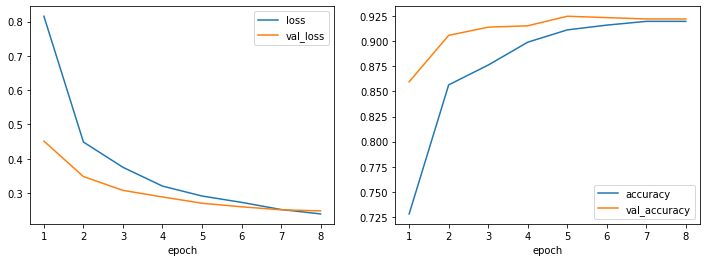

In [20]:
utils.plot_history(history_1)

In [21]:
model.evaluate(val_data)

23/23 [==============================] - 2s 74ms/step - loss: 0.2479 - accuracy: 0.9223


[0.24794422090053558, 0.9223433136940002]

In [22]:
# Load checkpoint weights (best weights) and evaluate model
model.load_weights(checkpoint_path)
model.evaluate(val_data)

23/23 [==============================] - 2s 75ms/step - loss: 0.2703 - accuracy: 0.9251


[0.27029189467430115, 0.9250681400299072]

In [23]:
# Saving model
model_path = 'feature_extraction_model'
model.save(model_path)

INFO:tensorflow:Assets written to: feature_extraction_model/assets


In [24]:
# Saved Model
utils.copytree(model_path, join(gdrive_path, model_path))
 
# TensorBoard Logs
utils.copytree("training_logs", join(gdrive_path, "training_logs"))

So, we got 92.5% accuracy on feature extraction model. Let's Fine Tune to improve our model.

### Fine Tune the Feature Extraction Model

In [25]:
# copy and load saved model from gdrive (if needed)
 
# utils.copytree(join(gdrive_path, "feature_extraction_model"), "feature_extraction_model")
# model = tf.keras.models.load_model('feature_extraction_model')

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [27]:
# Lets check which layers are trainable in feature_extraction_model
layers = [(l.name, l.trainable) for l in model.layers]
pd.DataFrame(layers, columns=['name', 'trainable'])

,name,trainable
0,input_layer,True
1,data_augmentation_layer,True
2,efficientnetb0,False
3,global_average_pooling_layer,True
4,output_layer,True


In [28]:
print('Trainable layers in base model :') # (EfficentNetB0)
layers = [(l.name, l.trainable) for l in model.layers[2].layers if l.trainable]
pd.DataFrame(layers, columns=['name', 'trainable'])

Trainable layers in base model :


,name,trainable


Let's unfreeeze the whole base model for fine tuning

In [29]:
# unfreeeze all layers of the base model
model.layers[2].trainable = True

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [30]:
# Create some callbacks
checkpoint_path = "checkpoints/fine_tuned_model/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

# if val_accuracy decreases for 3 epochs in a row, stop training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) 

# lr reduction callback (multiply the learning rate by 0.2 [reduce by 5x])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.2,
                                                 patience=1,
                                                 verbose=1,
                                                 min_lr=1e-8)

In [31]:
history_2 = model.fit(train_data,
                      epochs=100,
                      callbacks=[utils.create_tensorboard_callback('training_logs', 'fine_tuned_model'),
                                  checkpoint_callback,
                                  early_stopping,
                                  reduce_lr],
                      steps_per_epoch=len(train_data),
                      validation_data=val_data,
                      validation_steps=len(val_data))

Saving TensorBoard log files to: training_logs/fine_tuned_model/20210719-133734
Epoch 1/100
92/92 [==============================] - 82s 799ms/step - loss: 0.2530 - accuracy: 0.9100 - val_loss: 0.2323 - val_accuracy: 0.9223

Epoch 00001: val_accuracy improved from -inf to 0.92234, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 2/100
92/92 [==============================] - 62s 668ms/step - loss: 0.1967 - accuracy: 0.9328 - val_loss: 0.2173 - val_accuracy: 0.9251

Epoch 00002: val_accuracy improved from 0.92234 to 0.92507, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 3/100
92/92 [==============================] - 63s 679ms/step - loss: 0.1747 - accuracy: 0.9435 - val_loss: 0.2067 - val_accuracy: 0.9319

Epoch 00003: val_accuracy improved from 0.92507 to 0.93188, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 4/100
92/92 [==============================] - 63s 668ms/step - loss: 0.1589 - accuracy: 0.9430 - val_loss: 0.2002 -

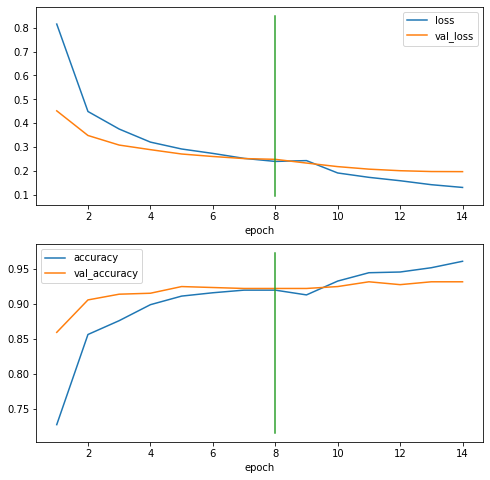

In [32]:
# utils.plot_history(history_2)
utils.compare_histories(history_1, history_2)

In [33]:
model.evaluate(val_data)

23/23 [==============================] - 2s 76ms/step - loss: 0.1963 - accuracy: 0.9319


[0.19627849757671356, 0.9318801164627075]

In [34]:
# Load checkpoint weights (best weights) and evaluate model
model.load_weights(checkpoint_path)
model.evaluate(val_data)

23/23 [==============================] - 2s 75ms/step - loss: 0.2067 - accuracy: 0.9319


[0.2067379653453827, 0.9318801164627075]

Well, we got almost 93.2% accuracy (increased from 92.5%) after fine tuning

In [35]:
# Saving model
model_path = 'fine_tuned_model'
model.save(model_path)

INFO:tensorflow:Assets written to: fine_tuned_model/assets


In [36]:
# Saved Model
utils.copytree(model_path, join(gdrive_path, model_path))

# TensorBoard Logs
utils.copytree("training_logs", join(gdrive_path, "training_logs"))

## Saving Things

We got our model (**fine_tuned_model with all layers unfrozen**). we saved them and uploaded to google drive for later use. We, also need to save some details.

In [37]:
# saving class names and copying to gdrive
data = {
    "class_names" : class_names,
    "image_shape" : IMAGE_SHAPE,
    "tf_version" : tf.__version__,
}

with open('data.json', 'w') as fl:
    json.dump(data, fl)

utils.copy("data.json", gdrive_path)

'/content/drive/MyDrive/Saved_Models/mini_flower/v1_efficientnetb0/data.json'

## Testing Our Model

In [38]:
# copy and load saved model from gdrive (if needed)

# utils.copytree(join(gdrive_path, "fine_tuned_model"), "fine_tuned_model")
# model = tf.keras.models.load_model('fine_tuned_model')

# utils.copy(join(gdrive_path, "data.json"), "data.json")
# with open('data.json', 'r') as fl:
#     data = json.load(fl)
# class_names = data['class_names']
# IMAGE_SHAPE = data['image_shape']

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


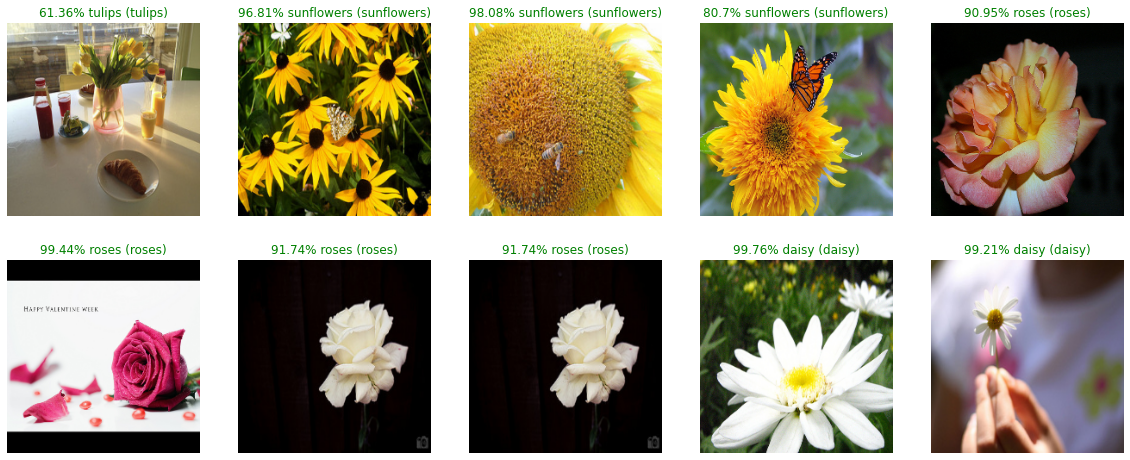

In [40]:
imgs, labels = utils.random_imgs(data_dir, rand_imgs=10, label_mode='int', label_class_names=class_names)
imgs = utils.load_images(imgs, image_shape=IMAGE_SHAPE)
utils.plot_pred_images(imgs, model.predict(imgs), labels, class_names=class_names)

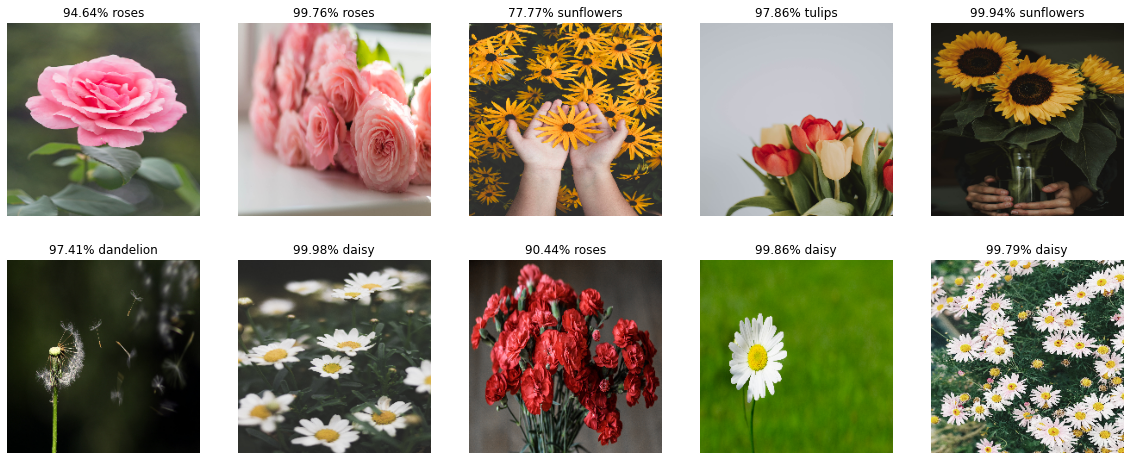

In [41]:
imgs = [
      'https://images.pexels.com/photos/736230/pexels-photo-736230.jpeg',
      'https://images.pexels.com/photos/617967/pexels-photo-617967.jpeg',
      'https://images.pexels.com/photos/1697912/pexels-photo-1697912.jpeg',
      'https://images.pexels.com/photos/2058498/pexels-photo-2058498.jpeg',
      'https://images.pexels.com/photos/1390433/pexels-photo-1390433.jpeg',
      'https://images.pexels.com/photos/289323/pexels-photo-289323.jpeg',
      'https://images.pexels.com/photos/1166869/pexels-photo-1166869.jpeg',
      'https://images.pexels.com/photos/136255/pexels-photo-136255.jpeg',
      'https://images.pexels.com/photos/597055/spring-daisy-blossom-flora-597055.jpeg',
      'https://images.pexels.com/photos/699964/pexels-photo-699964.jpeg',
      ]
imgs = utils.download_images(imgs, image_shape=IMAGE_SHAPE)
pred = model.predict(imgs)
utils.plot_pred_images(imgs, pred, class_names=class_names)

All right! Looks all good.

 ## Discuss our Model

In [42]:
# getting our y_test and y_pred in 'int' mode 
# so that we can do things easily
y_test = []
y_pred = []
for img, label in val_data.unbatch():
  y_test.append(tf.argmax(label, axis=0).numpy())
  pred = model.predict(tf.expand_dims(img, axis=0)).squeeze()
  y_pred.append(tf.argmax(pred, axis=0).numpy())

In [43]:
len(y_test), len(y_pred)

(734, 734)

In [44]:
print(y_test[:10])
print(y_pred[:10])

[1, 0, 3, 4, 2, 0, 4, 3, 1, 3]
[1, 0, 3, 4, 2, 0, 4, 3, 1, 3]


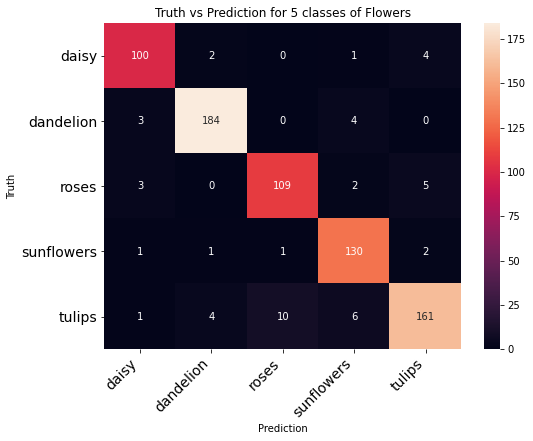

In [45]:
# plot a confusion metrics
utils.plot_confusion_matrix(y_test, y_pred, class_names=class_names, figsize=(8, 6), title="Truth vs Prediction for 5 classes of Flowers")

Hmmm, looks like our model is geting confused most with roses & tuilps.

Let's look at the F1 scores for these classes

In [46]:
from sklearn.metrics import classification_report, f1_score

In [47]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       daisy       0.93      0.93      0.93       107
   dandelion       0.96      0.96      0.96       191
       roses       0.91      0.92      0.91       119
  sunflowers       0.91      0.96      0.94       135
      tulips       0.94      0.88      0.91       182

    accuracy                           0.93       734
   macro avg       0.93      0.93      0.93       734
weighted avg       0.93      0.93      0.93       734



Let's plot a barchart for F1 scores

In [48]:
f1_scores = pd.Series(np.round(f1_score(y_test, y_pred, average=None), 2), index=class_names).sort_values()
f1_scores

roses         0.91
tulips        0.91
daisy         0.93
sunflowers    0.94
dandelion     0.96
dtype: float64

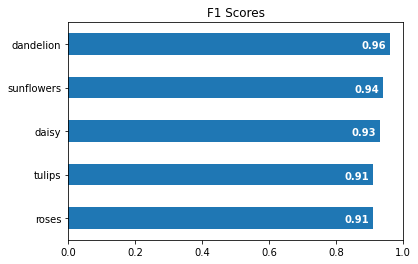

In [49]:
ax = f1_scores.plot.barh(title='F1 Scores', xlim=(0., 1.))
for i, v in enumerate(f1_scores):
    ax.text(v - 0.085, i - 0.1, str(v), color='white', fontweight='bold')

Not bad at all. But, just like the confusion metrics, tulips & roses are at the last as they get confused most.

Let's see those the wrong predictions

In [50]:
wrong_imgs = []
wrong_y_test = []
wrong_y_pred = []

for img, label in val_data.unbatch():
  pred = model.predict(tf.expand_dims(img, axis=0)).squeeze()
  if tf.argmax(label, axis=0) != tf.argmax(pred, axis=0):
    wrong_imgs.append(img)
    wrong_y_test.append(label)
    wrong_y_pred.append(pred)

In [51]:
# let's plot a figure to see these wrong predictions
utils.plot_pred_images(wrong_imgs, wrong_y_pred, wrong_y_test, class_names=class_names, rescale=1/255, save='Wrong Predictions.png')
# removed the output figure from the notebook for performance (saved as "Wrong Predictions.png" to analyze later)

From this figure, we can say most of the wrong predicted pictures were not clear to make good predictions. However, we are good to go.